In [26]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.options.display.max_columns = None

In [27]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_19_20.insert(2, 'Season', '2019-2020')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_20_21.insert(2, 'Season', '2020-2021')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_21_22.insert(2, 'Season', '2021-2022')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_22_23.insert(2, 'Season', '2022-2023')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')
gl_23_24.insert(2, 'Season', '2023-2024')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [28]:
# Correct the Win Streak and Lose Streak feature

def add_streak(game_log):
    # Ensure the Date column is in datetime format and sorted
    game_log['Date'] = pd.to_datetime(game_log['Date'])
    game_log = game_log.sort_values(by='Date').reset_index(drop=True)

    # Initialize streak columns
    win_streak = []
    lose_streak = []

    # Track streak counters
    current_win_streak = 0
    current_lose_streak = 0

    # Iterate over each row in the game log
    for _, row in game_log.iterrows():
        if row['Result'] == 'W':  # If the team won
            win_streak.append(current_win_streak)
            lose_streak.append(current_lose_streak)
            current_win_streak += 1
            current_lose_streak = 0
        else:  # If the team lost
            win_streak.append(current_win_streak)
            lose_streak.append(current_lose_streak)
            current_lose_streak += 1
            current_win_streak = 0

    # Add streak columns to the DataFrame
    game_log['Win Streak'] = win_streak
    game_log['Lose Streak'] = lose_streak

    return game_log

gl_19_20 = add_streak(gl_19_20)
gl_20_21 = add_streak(gl_20_21)
gl_21_20 = add_streak(gl_20_21)
gl_21_22 = add_streak(gl_21_22)
gl_22_23 = add_streak(gl_22_23)
gl_23_24 = add_streak(gl_23_24)

In [29]:
# Adding a feature that tells us how much rest the Fighting Illini had before their current game

def add_rest_time(game_log):
    # Ensure the Date column is in datetime format and sorted
    game_log['Date'] = pd.to_datetime(game_log['Date'])
    game_log = game_log.sort_values(by='Date').reset_index(drop=True)
    
    # Calculate rest days
    game_log['Rest Days'] = game_log['Date'].diff().dt.days.fillna(0).astype(int)
    
    # Fix any negative or unreasonable rest days
    game_log['Rest Days'] = game_log['Rest Days'].apply(lambda x: max(x, 0))  # No negative rest days

    # Insert Rest Days at the 7th index position
    game_log.insert(8, 'Rest Days', game_log.pop('Rest Days'))
    
    return game_log

gl_19_20 = add_rest_time(gl_19_20)
gl_20_21 = add_rest_time(gl_20_21)
gl_21_20 = add_rest_time(gl_20_21)
gl_21_22 = add_rest_time(gl_21_22)
gl_22_23 = add_rest_time(gl_22_23)
gl_23_24 = add_rest_time(gl_23_24)

In [30]:
# Adding a feature that calculates the rolling average of our stats

# List of statistical columns for which to calculate rolling averages
stats_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%',
                 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
                 'OPP FG', 'OPP FGA', 'OPP FG%', 'OPP 3P', 'OPP 3PA', 'OPP 3P%',
                 'OPP FT', 'OPP FTA', 'OPP FT%', 'OPP ORB', 'OPP TRB', 'OPP AST',
                 'OPP STL', 'OPP BLK', 'OPP TOV', 'OPP PF']

# Define a function to add rolling averages
def add_rolling_averages(df, window=5):
    for col in stats_columns:
        rolling_col_name = f"{col}_rolling_{window}"
        df[rolling_col_name] = df[col].rolling(window=window, min_periods=1).mean()
    return df

# Apply to each dataset
gl_19_20 = add_rolling_averages(gl_19_20)
gl_20_21 = add_rolling_averages(gl_20_21)
gl_21_22 = add_rolling_averages(gl_21_22)
gl_22_23 = add_rolling_averages(gl_22_23)
gl_23_24 = add_rolling_averages(gl_23_24)

In [31]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns='Unnamed: 0')
all_gl

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,PF,PA,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF.1,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5
0,2019-11-05,8:00p,2019-2020,REG,Nicholls State,NaN,False,Southland,0,-3.87,W,78,70,1,0,True,0,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29,27.0,61.000000,0.4430,5.000000,19.0,0.263000,19.00,29.000000,0.65500,17.00,50.000000,12.000000,6.0,2.000000,22.000000,78.000000,27.000000,66.000000,0.409000,8.000000,20.000000,0.400000,8.000000,9.000000,0.889000,3.000000,18.000000,13.0,11.000000,4.000000,16.000000,29.00
1,2019-11-08,9:00p,2019-2020,REG,Grand Canyon,NaN,False,WAC,3,-6.32,W,83,71,2,0,False,1,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23,28.0,62.500000,0.4480,4.500000,16.0,0.285500,20.00,29.500000,0.67750,16.50,48.000000,12.500000,5.5,1.000000,19.500000,80.500000,27.000000,63.500000,0.426000,8.000000,19.500000,0.410500,8.500000,12.500000,0.726000,4.500000,20.500000,12.5,7.500000,2.000000,13.500000,26.00
2,2019-11-10,9:00p,2019-2020,REG,Arizona,21.0,True,Pac-12,2,19.49,L,69,90,2,1,False,2,0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23,27.0,59.333333,0.4560,4.666667,16.0,0.294667,18.00,26.333333,0.68500,13.00,40.333333,11.666667,5.0,1.333333,20.333333,76.666667,29.333333,62.666667,0.469667,7.666667,18.333333,0.419667,10.666667,15.666667,0.711333,6.333333,24.333333,15.0,9.666667,2.333333,14.333333,25.00
3,2019-11-18,8:00p,2019-2020,REG,Hawaii,NaN,False,Big West,8,-1.27,W,66,53,3,1,True,0,1,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18,26.0,58.000000,0.4485,4.750000,15.0,0.325250,17.25,25.500000,0.67675,12.25,41.000000,12.250000,4.5,1.750000,19.000000,74.000000,28.000000,63.000000,0.446000,6.500000,19.250000,0.348750,8.500000,12.500000,0.700250,5.750000,24.500000,13.5,9.000000,2.250000,13.000000,23.25
4,2019-11-20,9:00p,2019-2020,REG,The Citadel,NaN,False,Southern,2,-13.82,W,85,57,4,1,True,1,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19,27.4,60.000000,0.4558,4.400000,15.6,0.293600,17.00,24.600000,0.69380,14.00,43.400000,13.200000,4.4,2.200000,17.800000,76.200000,26.600000,65.200000,0.413600,7.200000,23.000000,0.331600,7.800000,11.400000,0.703000,7.600000,25.000000,12.8,8.800000,2.200000,12.600000,22.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-18,8:30p,2023-2024,REG,Michigan,NaN,False,Big Ten,0,5.28,W,88,73,13,4,False,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18,25.0,61.400000,0.4084,6.200000,20.2,0.309000,20.00,26.000000,0.77360,10.60,35.400000,10.200000,6.2,4.000000,7.000000,77.400000,29.800000,65.000000,0.459200,3.800000,15.800000,0.239000,9.800000,13.000000,0.758400,9.200000,31.600000,11.6,2.800000,3.200000,7.800000,16.20
162,2024-01-21,6:09p,2023-2024,NCAA,Connecticut,1.0

In [52]:
# all_gl.to_csv(r'/Users/isaac/Desktop/personal/datadive24/Clean Datasets/All-Clean-Game-Logs.csv')

In [33]:
# Observe if Rest Days Were Correctly Calculated
all_gl['Rest Days'].unique()

array([ 0,  3,  2,  8,  6,  5,  4,  7,  1, 10, 13])

In [34]:
# Rename duplicate column names to be more concise
all_gl.rename(columns={'PF': 'Points For', 'PA' : 'Points Against', 'PF.1' : 'PF'}, inplace=True)
all_gl

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5
0,2019-11-05,8:00p,2019-2020,REG,Nicholls State,NaN,False,Southland,0,-3.87,W,78,70,1,0,True,0,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29,27.0,61.000000,0.4430,5.000000,19.0,0.263000,19.00,29.000000,0.65500,17.00,50.000000,12.000000,6.0,2.000000,22.000000,78.000000,27.000000,66.000000,0.409000,8.000000,20.000000,0.400000,8.000000,9.000000,0.889000,3.000000,18.000000,13.0,11.000000,4.000000,16.000000,29.00
1,2019-11-08,9:00p,2019-2020,REG,Grand Canyon,NaN,False,WAC,3,-6.32,W,83,71,2,0,False,1,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23,28.0,62.500000,0.4480,4.500000,16.0,0.285500,20.00,29.500000,0.67750,16.50,48.000000,12.500000,5.5,1.000000,19.500000,80.500000,27.000000,63.500000,0.426000,8.000000,19.500000,0.410500,8.500000,12.500000,0.726000,4.500000,20.500000,12.5,7.500000,2.000000,13.500000,26.00
2,2019-11-10,9:00p,2019-2020,REG,Arizona,21.0,True,Pac-12,2,19.49,L,69,90,2,1,False,2,0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23,27.0,59.333333,0.4560,4.666667,16.0,0.294667,18.00,26.333333,0.68500,13.00,40.333333,11.666667,5.0,1.333333,20.333333,76.666667,29.333333,62.666667,0.469667,7.666667,18.333333,0.419667,10.666667,15.666667,0.711333,6.333333,24.333333,15.0,9.666667,2.333333,14.333333,25.00
3,2019-11-18,8:00p,2019-2020,REG,Hawaii,NaN,False,Big West,8,-1.27,W,66,53,3,1,True,0,1,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18,26.0,58.000000,0.4485,4.750000,15.0,0.325250,17.25,25.500000,0.67675,12.25,41.000000,12.250000,4.5,1.750000,19.000000,74.000000,28.000000,63.000000,0.446000,6.500000,19.250000,0.348750,8.500000,12.500000,0.700250,5.750000,24.500000,13.5,9.000000,2.250000,13.000000,23.25
4,2019-11-20,9:00p,2019-2020,REG,The Citadel,NaN,False,Southern,2,-13.82,W,85,57,4,1,True,1,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19,27.4,60.000000,0.4558,4.400000,15.6,0.293600,17.00,24.600000,0.69380,14.00,43.400000,13.200000,4.4,2.200000,17.800000,76.200000,26.600000,65.200000,0.413600,7.200000,23.000000,0.331600,7.800000,11.400000,0.703000,7.600000,25.000000,12.8,8.800000,2.200000,12.600000,22.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-18,8:30p,2023-2024,REG,Michigan,NaN,False,Big Ten,0,5.28,W,88,73,13,4,False,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18,25.0,61.400000,0.4084,6.200000,20.2,0.309000,20.00,26.000000,0.77360,10.60,35.400000,10.200000,6.2,4.000000,7.000000,77.400000,29.800000,65.000000,0.459200,3.800000,15.800000,0.239000,9.800000,13.000000,0.758400,9.200000,31.600000,11.6,2.800000,3.200000,7.800000,16.20
162,2024-01-21,6:09p,2023-2024,NC

In [35]:
all_gl.isna().sum()

Date                 0
Time                 0
Season               0
Type                 0
Opponent             0
                    ..
OPP AST_rolling_5    0
OPP STL_rolling_5    0
OPP BLK_rolling_5    0
OPP TOV_rolling_5    0
OPP PF_rolling_5     0
Length: 82, dtype: int64

In [36]:
# Find the row with missing values
lindenwood = all_gl.loc[all_gl['Conf'].isna()]
lindenwood

,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,NaN,3,NaN,W,117,65,6,1,True,3,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30,33.0,61.6,0.529,6.4,17.8,0.3562,19.0,25.6,0.7372,12.0,40.2,19.0,6.6,2.8,14.6,91.4,26.4,65.4,0.409,7.4,24.4,0.3158,7.0,10.2,0.7012,8.6,25.0,12.2,8.4,1.4,15.2,22.2


In [37]:
# Fill in missing conference value
lindenwood['Conf'] = 'OVC'
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/294574576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['Conf'] = 'OVC'


,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,OVC,3,NaN,W,117,65,6,1,True,3,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30,33.0,61.6,0.529,6.4,17.8,0.3562,19.0,25.6,0.7372,12.0,40.2,19.0,6.6,2.8,14.6,91.4,26.4,65.4,0.409,7.4,24.4,0.3158,7.0,10.2,0.7012,8.6,25.0,12.2,8.4,1.4,15.2,22.2


In [38]:
# Fill in missing SRS value with an estimate
lindenwood['SRS'] = 42
lindenwood

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/1554679363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lindenwood['SRS'] = 42


,Date,Time,Season,Type,Opponent,Rank,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5
6,2019-11-26,8:00p,2019-2020,REG,Lindenwood,NaN,False,OVC,3,42,W,117,65,6,1,True,3,0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30,33.0,61.6,0.529,6.4,17.8,0.3562,19.0,25.6,0.7372,12.0,40.2,19.0,6.6,2.8,14.6,91.4,26.4,65.4,0.409,7.4,24.4,0.3158,7.0,10.2,0.7012,8.6,25.0,12.2,8.4,1.4,15.2,22.2


In [39]:
all_gl.loc[all_gl['Conf'].isna()] = lindenwood

In [40]:
all_gl.isna().sum()

Date                 0
Time                 0
Season               0
Type                 0
Opponent             0
                    ..
OPP AST_rolling_5    0
OPP STL_rolling_5    0
OPP BLK_rolling_5    0
OPP TOV_rolling_5    0
OPP PF_rolling_5     0
Length: 82, dtype: int64

/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/1866265331.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])


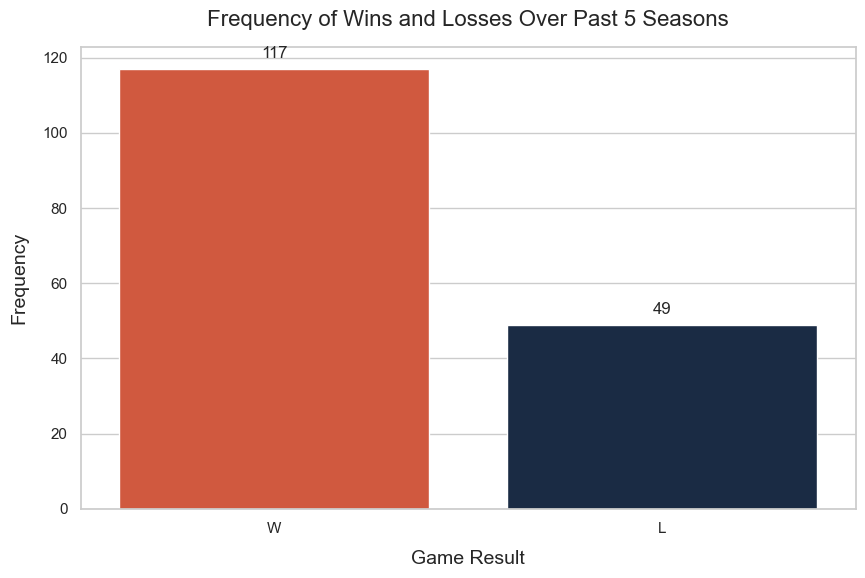

In [41]:
# Calculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()


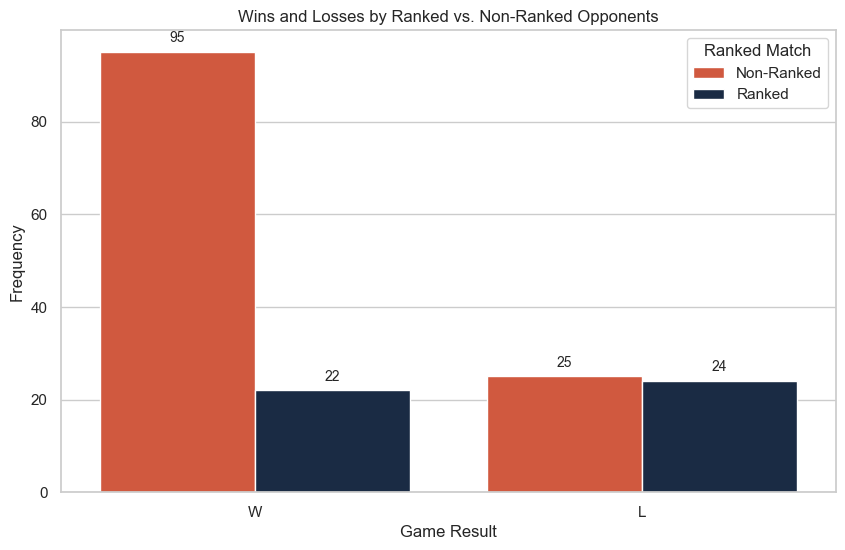

In [42]:
# Observe how well we do against ranked teams
plt.figure(figsize=(10, 6))

# Create a grouped bar plot using 'Result' and 'Ranked Match' columns
plot = sns.countplot(data=all_gl, x='Result', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds count at the top of the bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

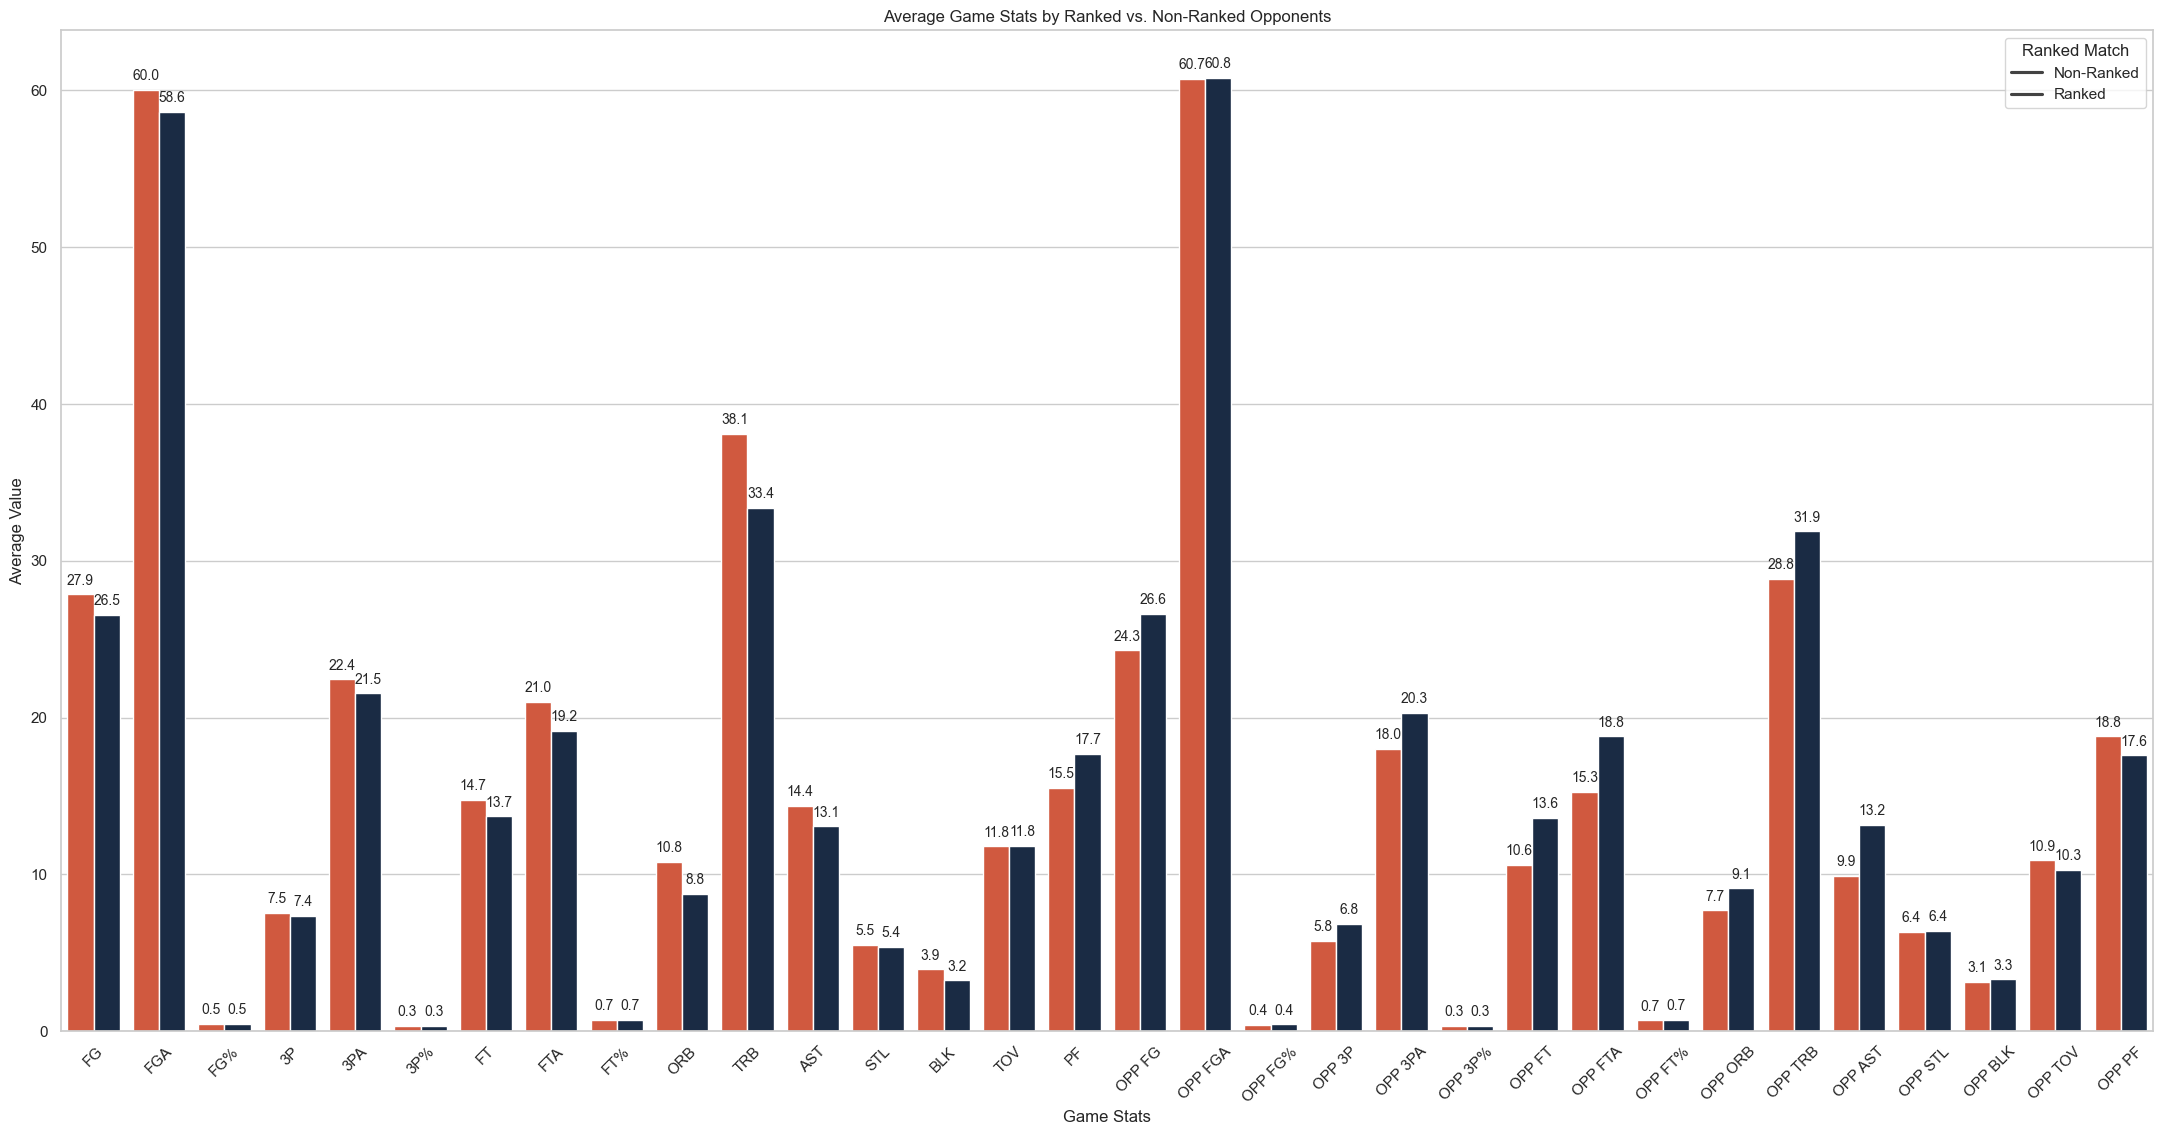

In [43]:
stats = [
    'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
    'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 
    'OPP FG', 'OPP FGA', 'OPP FG%', 'OPP 3P', 'OPP 3PA', 'OPP 3P%', 
    'OPP FT', 'OPP FTA', 'OPP FT%', 'OPP ORB', 'OPP TRB', 
    'OPP AST', 'OPP STL', 'OPP BLK', 'OPP TOV', 'OPP PF'
]

# Calculate the mean of each stat grouped by 'Ranked Match'
avg_stats = all_gl.groupby('Ranked Match')[stats].mean().reset_index()

# Reshape the data to have each stat as a separate entry for grouped plotting
avg_stats_melted = avg_stats.melt(id_vars='Ranked Match', var_name='Stat', value_name='Average')

plt.figure(figsize=(27, 13))
plot = sns.barplot(data=avg_stats_melted, x='Stat', y='Average', hue='Ranked Match', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Stats')
plt.ylabel('Average Value')
plt.title('Average Game Stats by Ranked vs. Non-Ranked Opponents')
plt.legend(title='Ranked Match', labels=['Non-Ranked', 'Ranked'])

# Adds average value at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, fmt="%.1f", label_type='edge', padding=5, fontsize=10)

plt.xticks(rotation=45)
plt.show()

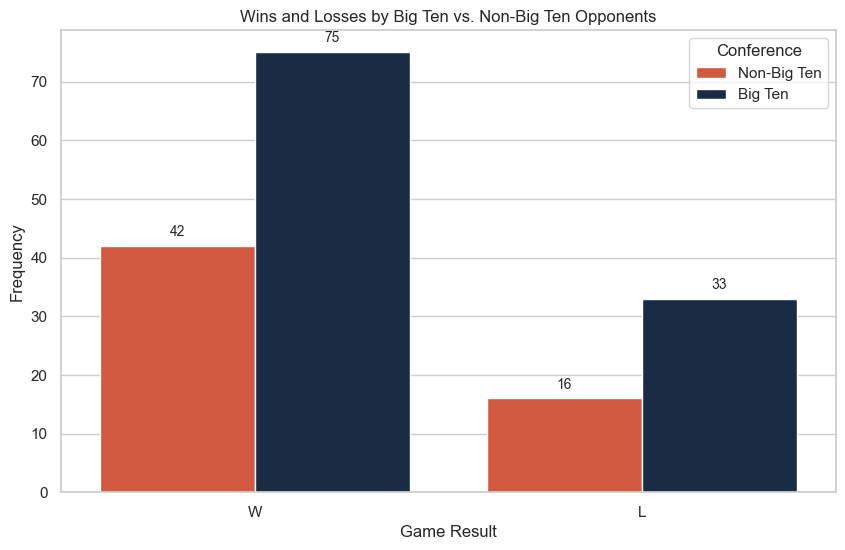

In [44]:
# What about for Conference vs. Non-Conference games
conf_gl = all_gl.copy()

conf_gl['Big_Ten_Opponent'] = conf_gl['Conf'].apply(lambda x: 'Big Ten' if x == 'Big Ten' else 'Non-Big Ten')

plt.figure(figsize=(10, 6))

plot = sns.countplot(data=conf_gl, x='Result', hue='Big_Ten_Opponent', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result')
plt.ylabel('Frequency')
plt.title('Wins and Losses by Big Ten vs. Non-Big Ten Opponents')
plt.legend(title='Conference', labels=['Non-Big Ten', 'Big Ten'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.show()

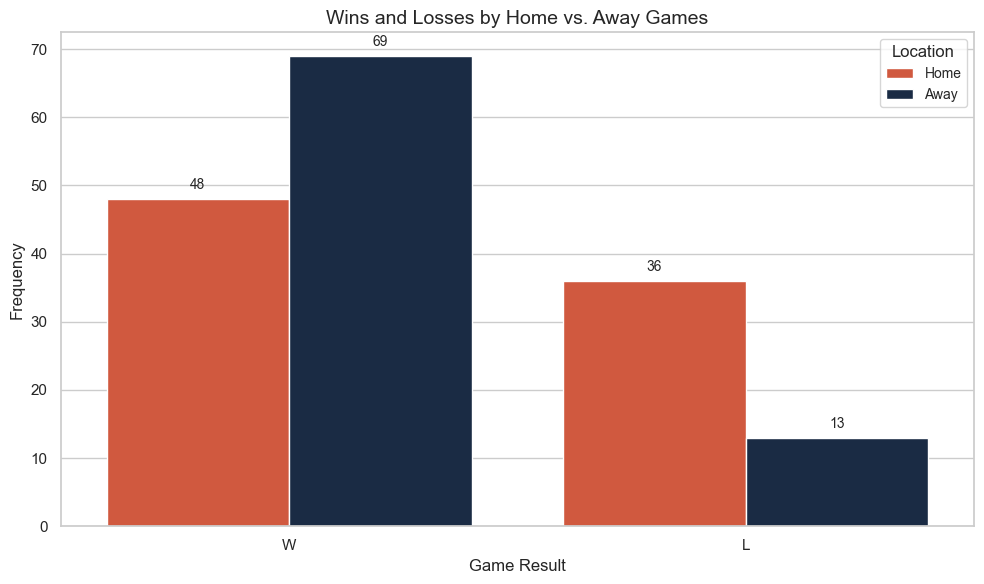

In [45]:
# What about for Home vs. Away games
plt.figure(figsize=(10, 6))

plot = sns.countplot(data=all_gl, x='Result', hue='Home Game', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Wins and Losses by Home vs. Away Games', fontsize=14)
plt.legend(title='Location', labels=['Home', 'Away'], fontsize=10)

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

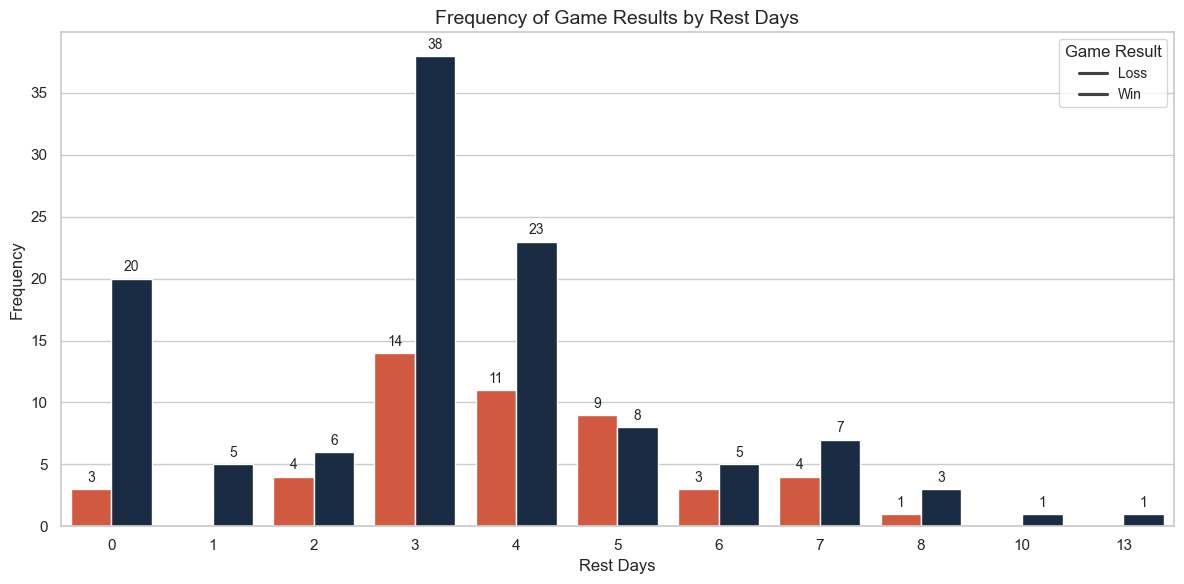

In [46]:
# Observe how the relationship between rest days and game results
plt.figure(figsize=(12, 6))

# Group data by Rest Days and Result, then count occurrences
rest_days_result = all_gl.groupby(['Rest Days', 'Result']).size().reset_index(name='Frequency')

plot = sns.barplot(data=rest_days_result, x='Rest Days', y='Frequency', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Rest Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of Game Results by Rest Days', fontsize=14)
plt.legend(title='Game Result', labels=['Loss', 'Win'], fontsize=10)

# Add value labels to each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

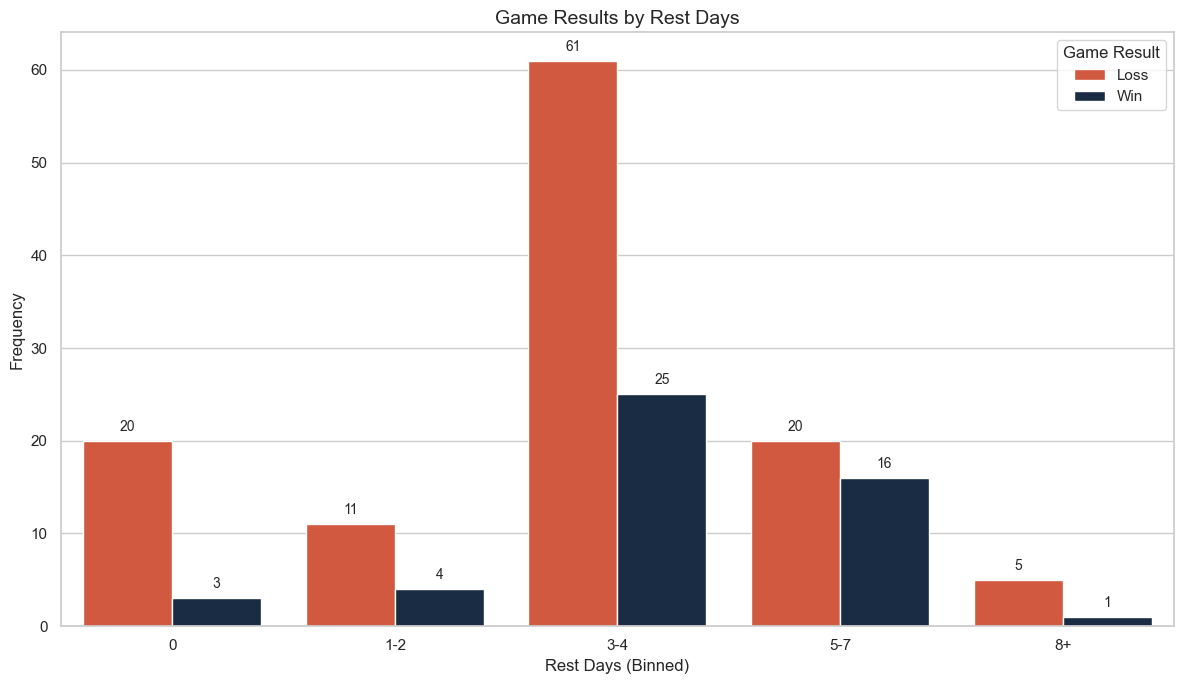

In [47]:
# Create bins for Rest Days and apply to our graph to better observe any trends
bins = [0, 1, 3, 5, 8, 100] 
labels = ['0', '1-2', '3-4', '5-7', '8+'] 
all_gl['Rest_Days_Binned'] = pd.cut(all_gl['Rest Days'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 7))

plot = sns.countplot(data=all_gl, x='Rest_Days_Binned', hue='Result', palette=['#E84A27', '#13294b'])

plt.xlabel('Rest Days (Binned)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Game Results by Rest Days', fontsize=14)
plt.legend(title='Game Result', labels=['Loss', 'Win'])

# Add counts at the top of each bar
for bar in plot.containers:
    plot.bar_label(bar, label_type='edge', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

In [48]:
# show the teams we have highest chance of winning against from lowest to highest

big_ten_schools = conf_gl[conf_gl['Big_Ten_Opponent'] == 'Big Ten']

big_ten_matchups = big_ten_schools.groupby('Opponent').agg(Total_Games=('Opponent', 'size'), 
    Wins=('Result', lambda x: (x == 'W').sum())).reset_index()

big_ten_matchups['Win Percentage'] = (big_ten_matchups['Wins'] / big_ten_matchups['Total_Games']) * 100

big_ten_matchups_sorted = big_ten_matchups.sort_values(by='Win Percentage', ascending=False)

big_ten_matchups_sorted

,Opponent,Total_Games,Wins,Win Percentage
3,Michigan,8,8,100.000000
5,Minnesota,7,7,100.000000
6,Nebraska,8,8,100.000000
12,Wisconsin,8,8,100.000000
7,Northwestern,10,8,80.000000
1,Iowa,9,7,77.777778
11,Rutgers,9,6,66.666667
0,Indiana,8,5,62.500000
8,Ohio State,9,5,55.555556
4,Michigan State,8,4,50.000000


/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/930791426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])
/var/folders/v4/50bt2ht50r17swtdj020c0580000gn/T/ipykernel_54761/930791426.py:3: UserWarning: 
The palette list has fewer values (2) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])


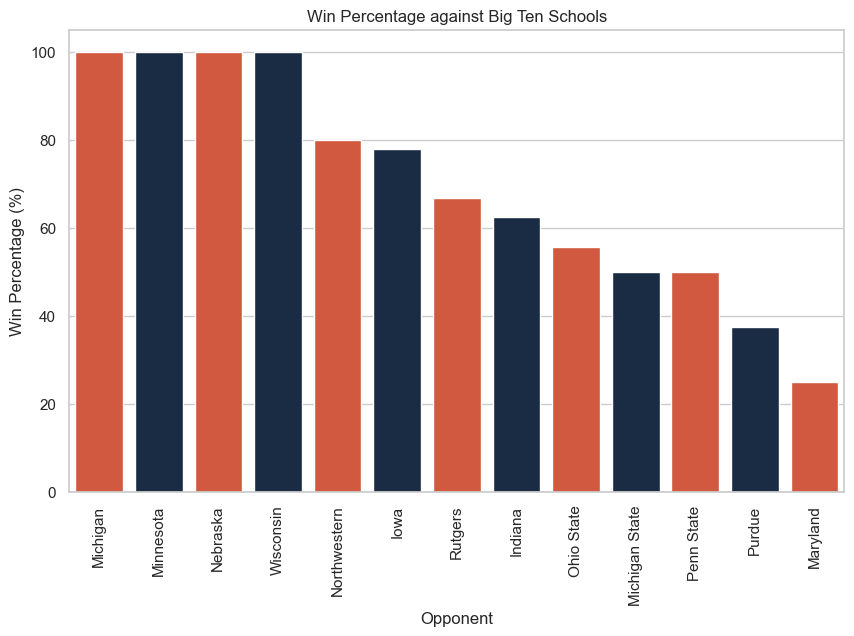

In [49]:
plt.figure(figsize=(10, 6))

sns.barplot(data=big_ten_matchups_sorted, x='Opponent', y='Win Percentage', palette=['#E84A27', '#13294b'])

plt.title('Win Percentage against Big Ten Schools')
plt.xlabel('Opponent')
plt.ylabel('Win Percentage (%)')
plt.xticks(rotation=90)

plt.show()

In [50]:
# Make a numeric only game log data frame for our correlation matrix
num_gl = all_gl.copy()
num_gl['Result'] = num_gl['Result'].apply(lambda x: 1 if x == 'W' else 0)
num_gl['Ranked Match'] = num_gl['Ranked Match'].apply(lambda x: 1 if x == True else 0)
num_gl['Home Game'] = num_gl['Home Game'].apply(lambda x: 1 if x == True else 0)
num_gl['Type'] = num_gl['Type'].astype('category').cat.codes
num_gl['Conf'] = num_gl['Conf'].astype('category').cat.codes
num_gl = num_gl.drop(columns=['Season','Date','Time','Rank','Opponent'])
num_gl

,Type,Ranked Match,Conf,Rest Days,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF,FG_rolling_5,FGA_rolling_5,FG%_rolling_5,3P_rolling_5,3PA_rolling_5,3P%_rolling_5,FT_rolling_5,FTA_rolling_5,FT%_rolling_5,ORB_rolling_5,TRB_rolling_5,AST_rolling_5,STL_rolling_5,BLK_rolling_5,TOV_rolling_5,PF_rolling_5,OPP FG_rolling_5,OPP FGA_rolling_5,OPP FG%_rolling_5,OPP 3P_rolling_5,OPP 3PA_rolling_5,OPP 3P%_rolling_5,OPP FT_rolling_5,OPP FTA_rolling_5,OPP FT%_rolling_5,OPP ORB_rolling_5,OPP TRB_rolling_5,OPP AST_rolling_5,OPP STL_rolling_5,OPP BLK_rolling_5,OPP TOV_rolling_5,OPP PF_rolling_5,Rest_Days_Binned
0,2,0,21,0,-3.87,1,78,70,1,0,1,0,0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29,27.0,61.000000,0.4430,5.000000,19.0,0.263000,19.00,29.000000,0.65500,17.00,50.000000,12.000000,6.0,2.000000,22.000000,78.000000,27.000000,66.000000,0.409000,8.000000,20.000000,0.400000,8.000000,9.000000,0.889000,3.000000,18.000000,13.0,11.000000,4.000000,16.000000,29.00,0
1,2,0,24,3,-6.32,1,83,71,2,0,0,1,0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23,28.0,62.500000,0.4480,4.500000,16.0,0.285500,20.00,29.500000,0.67750,16.50,48.000000,12.500000,5.5,1.000000,19.500000,80.500000,27.000000,63.500000,0.426000,8.000000,19.500000,0.410500,8.500000,12.500000,0.726000,4.500000,20.500000,12.5,7.500000,2.000000,13.500000,26.00,3-4
2,2,1,16,2,19.49,0,69,90,2,1,0,2,0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23,27.0,59.333333,0.4560,4.666667,16.0,0.294667,18.00,26.333333,0.68500,13.00,40.333333,11.666667,5.0,1.333333,20.333333,76.666667,29.333333,62.666667,0.469667,7.666667,18.333333,0.419667,10.666667,15.666667,0.711333,6.333333,24.333333,15.0,9.666667,2.333333,14.333333,25.00,1-2
3,2,0,7,8,-1.27,1,66,53,3,1,1,0,1,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18,26.0,58.000000,0.4485,4.750000,15.0,0.325250,17.25,25.500000,0.67675,12.25,41.000000,12.250000,4.5,1.750000,19.000000,74.000000,28.000000,63.000000,0.446000,6.500000,19.250000,0.348750,8.500000,12.500000,0.700250,5.750000,24.500000,13.5,9.000000,2.250000,13.000000,23.25,8+
4,2,0,20,2,-13.82,1,85,57,4,1,1,1,0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19,27.4,60.000000,0.4558,4.400000,15.6,0.293600,17.00,24.600000,0.69380,14.00,43.400000,13.200000,4.4,2.200000,17.800000,76.200000,26.600000,65.200000,0.413600,7.200000,23.000000,0.331600,7.800000,11.400000,0.703000,7.600000,25.000000,12.8,8.800000,2.200000,12.600000,22.40,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2,0,6,0,5.28,1,88,73,13,4,0,1,0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18,25.0,61.400000,0.4084,6.200000,20.2,0.309000,20.00,26.000000,0.77360,10.60,35.400000,10.200000,6.2,4.000000,7.000000,77.400000,29.800000,65.000000,0.459200,3.800000,15.800000,0.239000,9.800000,13.000000,0.758400,9.200000,31.600000,11.6,2.800000,3.200000,7.800000,16.20,0
162,1,1,4,3,26.70,0,52,77,29,9,0,2,0,32,63,0.508,6,27,0.222,16,27,0.593,11,43,17,7,3,12,12,26,69,0.377,3,14,0.214,8,11,0.727,9,30,8,7,3,14,19,26.8,63.000000,0.4264,6.000000,21.4,0.286800,19.60,27.000000,0.72860,11.40,37.800000,11.400000,7.0,3.400000,8.000000,73.600000,29.200000,65.000000,0.450600,3.400000,14.800000,0.229200,10.400000,13.800000,0.761000,8.600000,30.800000,11.2,3.4

In [51]:
# Create correlation matrix
gl_corr = num_gl.corr()
gl_corr

ValueError: could not convert string to float: '3-4'

In [ ]:
# The variables that have the most affect on the Result column in order
pd.set_option('display.max_rows', None)
result_corr = gl_corr['Result'].drop('Result')
result_corr = result_corr.abs().sort_values(ascending=False)
result_corr = result_corr.reset_index()
result_corr.columns = ['Variable', 'Correlation with Result']
result_corr

In [ ]:
# Visualization to easily view what variables had the highest correlation with result
plt.figure(figsize=(12, 8))
sns.barplot(data=result_corr, x='Variable', y='Correlation with Result', color='orange')
plt.xticks(rotation=90)
plt.title('Correlation of Variables with Game Result')
plt.xlabel('Variable')
plt.ylabel('Correlation with Result')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore') #mutes warnings for 2021 and 2122 

s1920 = ['19-20', '19-20', '19-20', '19-20', '19-20', '19-20', '19-20', 
         '19-20', '19-20', '19-20' , '19-20', '19-20', '19-20', '19-20']
roster_19_20['Season'] = s1920 # add season columns to rosters for analysis later

s2021 = ['20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21'
         '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21']
roster_20_21['Season'] = s2021
roster_20_21['Season'][6] = '20-21'

s2122 = ['21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22'
         '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22']
roster_21_22['Season'] = s2122
roster_21_22['Season'][6] = '21-22'


s2223 = ['22-23', '22-23', '22-23', '22-23', '22-23',
         '22-23', '22-23', '22-23', '22-23', '22-23', 
         '22-23', '22-23', '22-23', '22-23', '22-23']
roster_22_23['Season'] = s2223

s2324 = ['23-24', '23-24', '23-24', '23-24', '23-24', '23-24',
         '23-24', '23-24', '23-24', '23-24', '23-24', '23-24'
         ,'23-24']
roster_23_24['Season'] = s2324


all_rosters = pd.concat([roster_19_20, roster_20_21, roster_21_22, roster_22_23, roster_23_24], ignore_index= True)
count_players = all_rosters['Player'].value_counts()
multiple_season = count_players[count_players > 1].index.to_list()
attributes = ['Player', 'Season', 'PTS', 'AST']
roster_performance = all_rosters[all_rosters['Player'].isin(multiple_season)][attributes]
player_pts = roster_performance.pivot(index = 'Season', columns = 'Player', values = 'PTS')
plt.figure(figsize = (10,8))
player_pts
for player in player_pts.columns :
    plt.plot(player_pts.index, player_pts[player], marker = 'o', label = player)

plt.title('Points Per Game Trends for Players Across Seasons')
plt.xlabel('Season')
plt.ylabel('Points Per Game')
plt.xticks(rotation=45)
plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
if 'Pos' in all_rosters.columns and 'PTS' in all_rosters.columns: 
    position = all_rosters['Pos'].unique()
    for pos in position:
        position_data = all_rosters[all_rosters['Pos'] == pos]
        pts_for_pos = position_data.pivot(index = 'Season', columns = 'Player', values = 'PTS')
        plt.figure(figsize = (10,6))
        for player in pts_for_pos.columns: 
            plt.plot(pts_for_pos.index, pts_for_pos[player], marker = 'o', label = player)
        plt.title(f'Points Per Game Trends by Season for {pos} Position')
        plt.xlabel('Season')
        plt.ylabel('Points Per Game')
        plt.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
#Code below makes a linear regression model predicting points based on various metrics 

all_rosters[['Feet', 'Inches']] = all_rosters['Height'].str.split('-', expand= True)
all_rosters['Feet'] = all_rosters['Feet'].astype(int)
all_rosters['Inches'] = all_rosters['Inches'].astype(int)
all_rosters['Height(inches)'] = all_rosters['Feet'] * 12 + all_rosters['Inches']
all_rosters.drop(columns = ['Unnamed: 0']) #converts the height to inches for linear regression model and also cleans it up a little
all_rosters['Predicted PTS'] = all_rosters['PTS']

In [ ]:
x = all_rosters[['PTS', 'AST', 'Height(inches)', 'Weight']]
y = all_rosters['Predicted PTS']

drop_na = pd.concat([x, y], axis = 1).dropna()

x_c = drop_na[['PTS', 'AST', 'Height(inches)', 'Weight']]
y_c = drop_na['Predicted PTS']

x_train, x_test, y_train, y_test = train_test_split(x_c, y_c, test_size = 0.3, random_state = 42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
predictions

In [ ]:
y_test

In [ ]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("MSE = " + mse.astype(str) + "\n" + "R^2 = " + r2.astype(str))

In [ ]:
all_rosters

In [ ]:
selected_columns = [
    'Player', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', 
    '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 
    'BLK', 'TOV', 'PTS', 'Height(inches)'
]

df_selected_outliers = all_rosters[selected_columns]
df_selected_outliers

In [ ]:
# looking for outliers within specific features

plt.figure(figsize=(15, 10))
df_selected_outliers.boxplot()
plt.xticks(rotation = 90) 
plt.title("Boxplot of Selected Features to Identify Outliers")
plt.show()

In [ ]:
from scipy.stats import zscore

z_scores = df_selected_outliers.select_dtypes(include=['float64', 'int']).apply(zscore)

outliers = (z_scores.abs() > 3).any(axis=1)
df_outliers = df_selected_outliers[outliers]
df_outliers

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_selected_outliers[['MP', 'PTS']])
plt.title("Boxplot of Minutes Played and Points")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.show()

In [ ]:
numeric_roster = all_rosters.select_dtypes(include=[np.number])
corr = numeric_roster.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')
plt.show()